# 1. Convert all xls files into csv format

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import cos, radians

In [2]:
folder_path = "../../Datasets/NYC_House_Price_Dataset/"

# for foldername, _, filenames in os.walk(folder_path + "xls/"):
#     for filename in filenames:
#         if filename.endswith(".xls"):
#             file_path = os.path.join(foldername, filename)
#             output_path = os.path.join(folder_path + "csv/", filename.replace(".xls", ".csv"))

#             try:
#                 df = pd.read_excel(file_path, engine="xlrd")
#                 df.columns = df.columns.str.strip()
#                 df.to_csv(output_path, index=False, encoding='utf-8-sig')
#                 print(f"successful conversion: {file_path} -> {output_path}")
#             except Exception as e:
#                 print(f"failed conversion: {file_path}, error: {e}")

# 2. Map coordinates generation

In [3]:
# year = ["200" + str(i) for i in range(3, 10)]
# year += ["20" + str(i) for i in range(10, 16)]
# district_dict = {"bronx": [2, "BX"], "brooklyn": [3, "BK"], "manhattan": [1, "MN"], "queens": [4, "QN"], "statenisland": [5, "SI"]}

In [4]:
# all_pos = set()
# for y in year:
#     for d in district_dict.keys():
#         file_path = folder_path + "csv/" + y + "_" + d + ".csv"
#         cur_df = pd.read_csv(file_path, encoding="utf-8-sig", low_memory=False)
#         address_number = set(cur_df["ADDRESS"].unique())
#         all_pos = all_pos.union(address_number)
#         print(f"{y + d} -> {len(address_number)}")
# print(len(all_pos))

In [5]:
# import pluto csv file to get the lng and lat using bbl
pluto_path = os.path.join(folder_path, "nyc_pluto_24v4_1_csv/pluto_24v4_1.csv")
pluto = pd.read_csv(pluto_path, encoding="utf-8-sig", low_memory=False)

In [6]:
# Print initial shape
print(f"Original shape: {pluto.shape}")

# Remove rows where latitude or longitude is null
pluto = pluto.dropna(subset=["latitude", "longitude"])

# Print final shape and verification info
print(f"Shape after removing null locations: {pluto.shape}")
print("\nVerification:")
print(f"Null values in latitude: {pluto['latitude'].isnull().sum()}")
print(f"Null values in longitude: {pluto['longitude'].isnull().sum()}")

# Optional: Display sample of cleaned data
print("\nSample of cleaned location data:")
print(pluto[["borough", "block", "lot", "latitude", "longitude"]].head())

Original shape: (858642, 92)
Shape after removing null locations: (857421, 92)

Verification:
Null values in latitude: 0
Null values in longitude: 0

Sample of cleaned location data:
  borough  block  lot   latitude  longitude
0      BK   7604   47  40.625779 -73.953658
1      BK   1304    1  40.664671 -73.956901
2      BK   1304   58  40.665104 -73.955675
3      BK   1294    1  40.666423 -73.958074
4      BK   1302    1  40.665062 -73.958101


In [7]:
# pluto.isnull().sum()

In [8]:
# pluto.columns

Add latitude and longitude

In [9]:
def process_csv_with_location(input_file, pluto_location, borough_map):
    # Read CSV
    print(f"Processing {input_file}...")
    df = pd.read_csv(input_file, encoding="utf-8-sig", low_memory=False)
    
    # Add borough code and merge with location data
    df["borough_code"] = df["BOROUGH"].map(borough_map)
    df = df.merge(
        pluto_location,
        how="left",
        left_on=["borough_code", "BLOCK", "LOT"],
        right_on=["borough", "block", "lot"]
    )
    # missing_lot_mask = df["latitude"].isna()
    
    # if missing_lot_mask.any():
    #     print(f"Filling missing LOT locations for {missing_lot_mask.sum()} rows...")
        
    #     block_location_map = pluto_location.groupby(["borough", "block"])[["latitude", "longitude"]].first()
        
    #     df.loc[missing_lot_mask, ["latitude", "longitude"]] = df[missing_lot_mask].apply(
    #         lambda row: block_location_map.loc[(row["borough_code"], row["BLOCK"])]
    #         if (row["borough_code"], row["BLOCK"]) in block_location_map.index else (None, None),
    #         axis=1, result_type="expand"
    #     )
    
    # Clean up columns
    df.drop(["borough_code", "borough", "block", "lot"], axis=1, inplace=True)
    
    # Remove rows with missing locations
    rows_before = len(df)
    df = df.dropna(subset=["latitude", "longitude"])
    rows_after = len(df)
    
    print("-------------------------------------------------------------")
    print(f"file name: {input_file}")
    print(f"Rows before cleaning: {rows_before}")
    print(f"Rows after cleaning: {rows_after}")
    print(f"Removed {rows_before - rows_after} rows with missing locations")
    print("-------------------------------------------------------------")
    
    return df, rows_before, rows_before - rows_after

# Prepare PLUTO location data
pluto_location = pluto[["borough", "block", "lot", "latitude", "longitude"]]
borough_map = {1: "MN", 2: "BX", 3: "BK", 4: "QN", 5: "SI"}

# Process all CSV files
csv_folder = folder_path + "csv/"
output_folder = folder_path + "csv_with_location/"

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Process each CSV file
total_rows = 0
clean_r_cnt = 0
for filename in os.listdir(csv_folder):
    if filename.endswith(".csv"):
        input_path = os.path.join(csv_folder, filename)
        output_path = os.path.join(output_folder, f"located_{filename}")
        
        # Process file
        processed_df, total_r, clean_r = process_csv_with_location(input_path, pluto_location, borough_map)
        total_rows += total_r
        clean_r_cnt += clean_r
        
        # Save processed file
        processed_df.to_csv(output_path, index=False)
        print(f"Saved processed file to: {output_path}\n")

print("All files processed successfully!")
print(f"Total rows processed: {total_rows}")
print(f"Total rows removed due to missing locations: {clean_r_cnt}")

Processing ../../Datasets/NYC_House_Price_Dataset/csv/2006_bronx.csv...
-------------------------------------------------------------
file name: ../../Datasets/NYC_House_Price_Dataset/csv/2006_bronx.csv
Rows before cleaning: 10695
Rows after cleaning: 9116
Removed 1579 rows with missing locations
-------------------------------------------------------------
Saved processed file to: ../../Datasets/NYC_House_Price_Dataset/csv_with_location/located_2006_bronx.csv

Processing ../../Datasets/NYC_House_Price_Dataset/csv/2012_statenisland.csv...
-------------------------------------------------------------
file name: ../../Datasets/NYC_House_Price_Dataset/csv/2012_statenisland.csv
Rows before cleaning: 6231
Rows after cleaning: 5682
Removed 549 rows with missing locations
-------------------------------------------------------------
Saved processed file to: ../../Datasets/NYC_House_Price_Dataset/csv_with_location/located_2012_statenisland.csv

Processing ../../Datasets/NYC_House_Price_Dataset

Combine into one file

In [10]:
def merge_all_files(input_folder, output_file):
    """
    Merge all processed CSV files and sort by sale date
    """
    print("Starting file merge process...")
    
    # Get all CSV files
    files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
    
    # Initialize empty list to store DataFrames
    dfs = []
    
    # Process each file
    for filename in files:
        print(f"Reading {filename}...")
        filepath = os.path.join(input_folder, filename)
        df = pd.read_csv(filepath)
        dfs.append(df)
    
    # Concatenate all DataFrames
    print("Merging files...")
    final_df = pd.concat(dfs, ignore_index=True)
    
    # Convert and sort by sale date
    print("Sorting by sale date...")
    final_df["SALE DATE"] = pd.to_datetime(final_df["SALE DATE"])
    final_df = final_df.sort_values("SALE DATE")
    final_df.rename(columns={"latitude": "LAT"}, inplace=True)
    final_df.rename(columns={"longitude": "LNG"}, inplace=True)
    
    # Save merged file
    print(f"Saving merged file to {output_file}...")
    final_df.to_csv(output_file, index=False)
    
    print(f"\nMerge complete!")
    print(f"Total records: {len(final_df)}")
    print(f"Date range: {final_df['SALE DATE'].min()} to {final_df['SALE DATE'].max()}")
    
    return final_df

# Execute the merge
input_folder = folder_path + "csv_with_location/"
output_file = folder_path + "nyc_sales_03_15.csv"

merged_df = merge_all_files(input_folder, output_file)

Starting file merge process...
Reading located_2014_bronx.csv...
Reading located_2014_statenisland.csv...
Reading located_2012_queens.csv...
Reading located_2003_queens.csv...
Reading located_2005_brooklyn.csv...
Reading located_2010_brooklyn.csv...
Reading located_2006_queens.csv...
Reading located_2004_statenisland.csv...
Reading located_2008_manhattan.csv...
Reading located_2006_bronx.csv...
Reading located_2012_bronx.csv...
Reading located_2010_statenisland.csv...
Reading located_2011_brooklyn.csv...
Reading located_2004_brooklyn.csv...
Reading located_2003_brooklyn.csv...
Reading located_2015_bronx.csv...
Reading located_2010_queens.csv...
Reading located_2009_brooklyn.csv...
Reading located_2015_statenisland.csv...
Reading located_2015_manhattan.csv...
Reading located_2006_manhattan.csv...
Reading located_2011_manhattan.csv...
Reading located_2005_statenisland.csv...
Reading located_2013_bronx.csv...
Reading located_2012_manhattan.csv...
Reading located_2004_queens.csv...
Reading

# 3. EDA for merged file

In [11]:
nyc_sales_path = os.path.join(folder_path, "nyc_sales_03_15.csv")
nyc_df = pd.read_csv(nyc_sales_path, encoding="utf-8-sig", low_memory=False)

In [12]:
nyc_df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'LAT', 'LNG'],
      dtype='object')

Already remove nan value, drop some unused columns then remove some rows with zero values

In [13]:
nyc_df.drop(columns=["NEIGHBORHOOD", "EASE-MENT", "ADDRESS", "APARTMENT NUMBER"], inplace=True)

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
columns_convert = ["BUILDING CLASS CATEGORY", "TAX CLASS AT PRESENT", "TAX CLASS AT TIME OF SALE", "BUILDING CLASS AT PRESENT", "BUILDING CLASS AT TIME OF SALE"]
for col in columns_convert:
    nyc_df[col] = le.fit_transform(nyc_df[col])

In [15]:
def remove_zero_rows(df, columns_to_check):
    # Print initial shape
    print(f"Initial shape: {df.shape}")
    
    # Create a mask for rows where any specified column has zero
    mask = ~(df[columns_to_check] == 0).any(axis=1)
    
    # Apply the mask and get the filtered DataFrame
    df = df[mask]
    
    # Print results
    print(f"Final shape: {df.shape}")
    print(f"Removed {len(df) - len(df)} rows")
    
    return df

In [16]:
columns_to_check = ["SALE PRICE", "LAND SQUARE FEET", "GROSS SQUARE FEET", "YEAR BUILT", "SALE DATE"]
nyc_df = remove_zero_rows(nyc_df, columns_to_check)

Initial shape: (927918, 19)
Final shape: (433820, 19)
Removed 0 rows


plot distribution before removing outliers

In [17]:
def plot_kde_distributions(
        df: pd.DataFrame,
        columns: list,
        bw_adjust: float = 0.3, 
        figsize: tuple = (14, 6)
    ) -> None:
    for i in range(0, len(columns), 2):
        plt.figure(figsize=figsize)
        
        # First subplot
        plt.subplot(1, 2, 1)
        sns.kdeplot(data=df, x=columns[i], bw_adjust=bw_adjust, fill=True)
        plt.title(f'{columns[i]} Distribution (KDE)')
        plt.xlabel(columns[i])
        print(df[columns[i]].min())
        print(df[columns[i]].max())
        
        # Second subplot (if available)
        if i + 1 < len(columns):
            plt.subplot(1, 2, 2)
            sns.kdeplot(data=df, x=columns[i+1], bw_adjust=bw_adjust, fill=True)
            plt.title(f'{columns[i+1]} Distribution (KDE)')
            plt.xlabel(columns[i+1])
            print(df[columns[i+1]].min())
            print(df[columns[i+1]].max())
        
        plt.tight_layout()
        plt.show()

In [18]:
columns_to_plot = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
                   'TOTAL UNITS', 'LAND SQUARE FEET',
                   'GROSS SQUARE FEET', 'YEAR BUILT',
                   'SALE PRICE']

In [19]:
from scipy import stats


def remove_outliers_fitted(df, col: str, upper_quantile=0.99, lower_quantile=0.01):
    data = df[col].values
    shift = np.min(data)
    if shift <= 0:
        shift = abs(shift) + 1e-8
        data = data + shift
    
    transformed_data, lambda_val = stats.boxcox(data)

    lower = np.percentile(transformed_data, lower_quantile * 100)
    upper = np.percentile(transformed_data, upper_quantile * 100)

    lower_original = (lower * lambda_val + 1) ** (1 / lambda_val) - shift
    upper_original = (upper * lambda_val + 1) ** (1 / lambda_val) - shift
    print(f"lower_original: {lower_original}, upper_original: {upper_original}")

    df = df[(df[col] >= lower_original) & (df[col] <= upper_original)]
    return df

In [20]:
# # handle year built based on fact
nyc_df = nyc_df[nyc_df["YEAR BUILT"] > 1626]
outliers = {
    'LAND SQUARE FEET': (0.95, 0.05),
    'GROSS SQUARE FEET': (0.95, 0.05),
    'SALE PRICE': (0.999, 0.05)
}
for col in outliers.keys():
    print("before: ", len(nyc_df))
    nyc_df = remove_outliers_fitted(nyc_df, col, outliers[col][0], outliers[col][1])
    print("after: ", len(nyc_df))
    print("--------------------------")

before:  433817
lower_original: 1402.9999999999932, upper_original: 7481.000000000007
after:  383020
--------------------------
before:  383020
lower_original: 1062.0000000000014, upper_original: 5514.000000000008
after:  344740
--------------------------
before:  344740
lower_original: 97498.99999999984, upper_original: 7899998.999999996
after:  327159
--------------------------


0
33
0
31


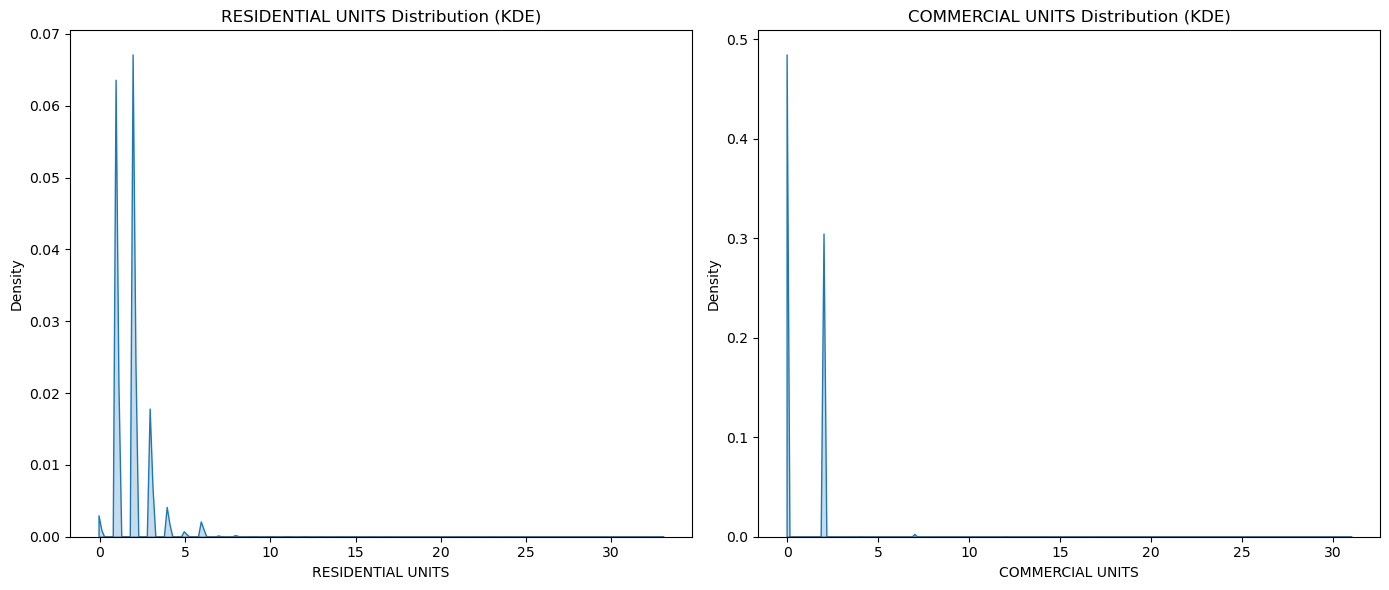

0
33
1403
7481


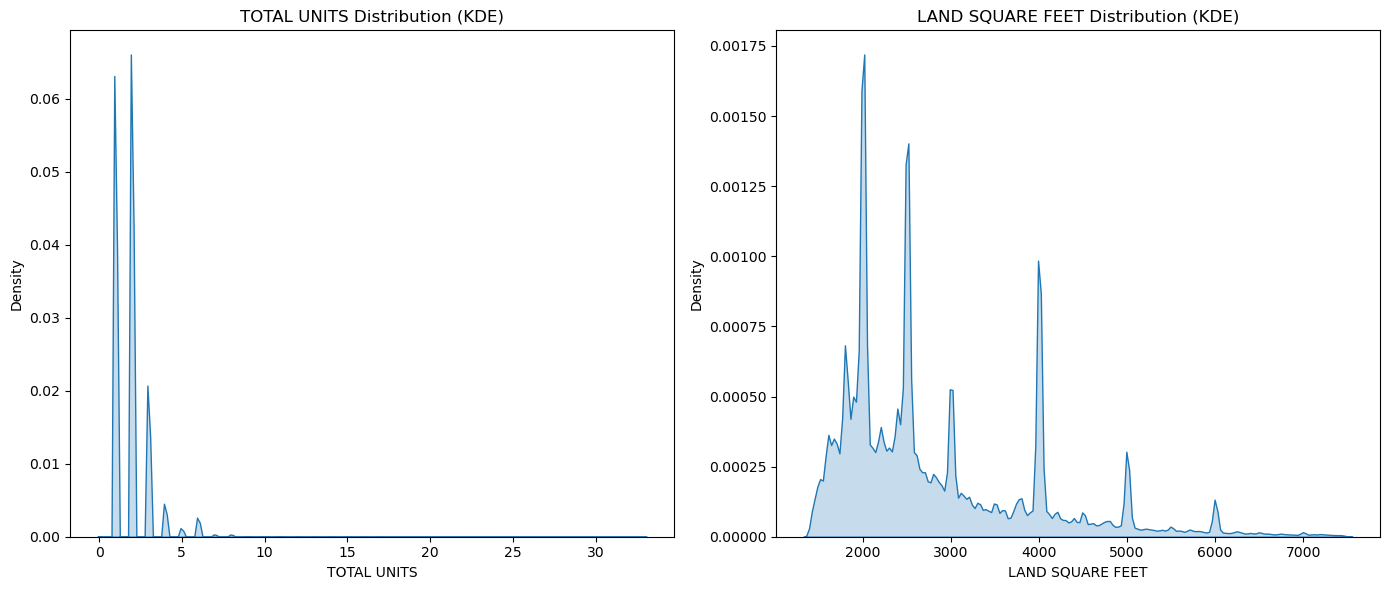

1063
5514
1798
2016


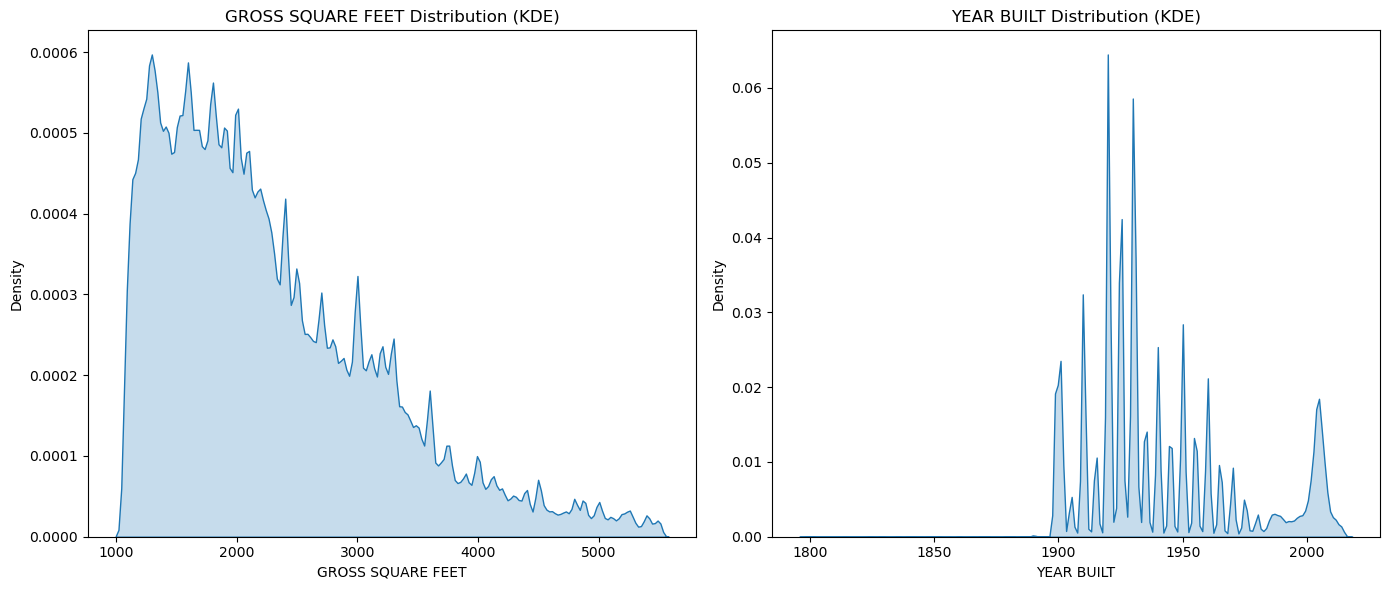

97500
7850000


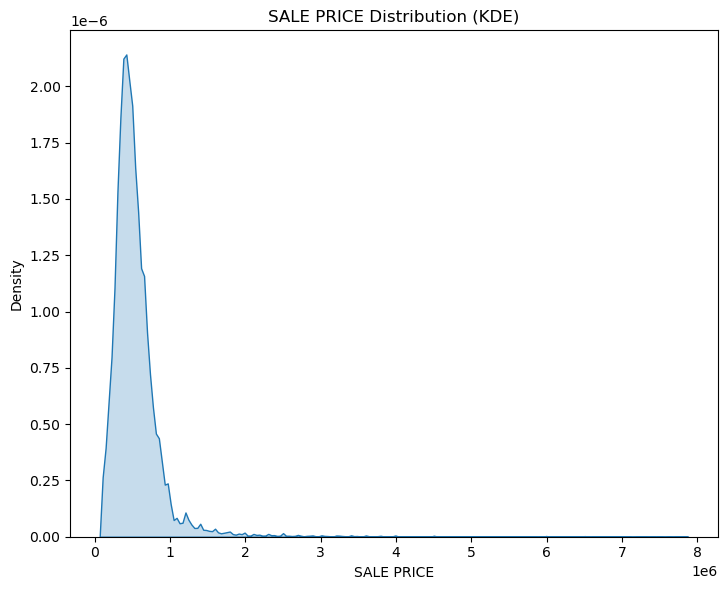

In [21]:
plot_kde_distributions(nyc_df, columns_to_plot)

convert the time, time interval: 1 month

In [22]:
# convert trade time into year+month, as the time interval size is one month
nyc_df["SALE DATE"] = pd.to_datetime(nyc_df["SALE DATE"])
# nyc_df['SALE MONTH'] = nyc_df['SALE DATE'].dt.strftime('%Y-%m')
nyc_df = nyc_df[nyc_df["SALE DATE"] >= '2003-01-01']
nyc_df = nyc_df.sort_values(by="SALE DATE")
nyc_df['MONTH'] = nyc_df["SALE DATE"].dt.year * 12 + nyc_df["SALE DATE"].dt.month
nyc_df['DAYS'] = (nyc_df['SALE DATE'] - pd.Timestamp('2003-01-01')).dt.days

In [23]:
nyc_df["MONTH"].unique()

array([24037, 24038, 24039, 24040, 24041, 24042, 24043, 24044, 24045,
       24046, 24047, 24048, 24049, 24050, 24051, 24052, 24053, 24054,
       24055, 24056, 24057, 24058, 24059, 24060, 24061, 24062, 24063,
       24064, 24065, 24066, 24067, 24068, 24069, 24070, 24071, 24072,
       24073, 24074, 24075, 24076, 24077, 24078, 24079, 24080, 24081,
       24082, 24083, 24084, 24085, 24086, 24087, 24088, 24089, 24090,
       24091, 24092, 24093, 24094, 24095, 24096, 24097, 24098, 24099,
       24100, 24101, 24102, 24103, 24104, 24105, 24106, 24107, 24108,
       24109, 24110, 24111, 24112, 24113, 24114, 24115, 24116, 24117,
       24118, 24119, 24120, 24121, 24122, 24123, 24124, 24125, 24126,
       24127, 24128, 24129, 24130, 24131, 24132, 24133, 24134, 24135,
       24136, 24137, 24138, 24139, 24140, 24141, 24142, 24143, 24144,
       24145, 24146, 24147, 24148, 24149, 24150, 24151, 24152, 24153,
       24154, 24155, 24156, 24157, 24158, 24159, 24160, 24161, 24162,
       24163, 24164,

build distance column

In [24]:
lat = nyc_df["LAT"]
lng = nyc_df["LNG"]

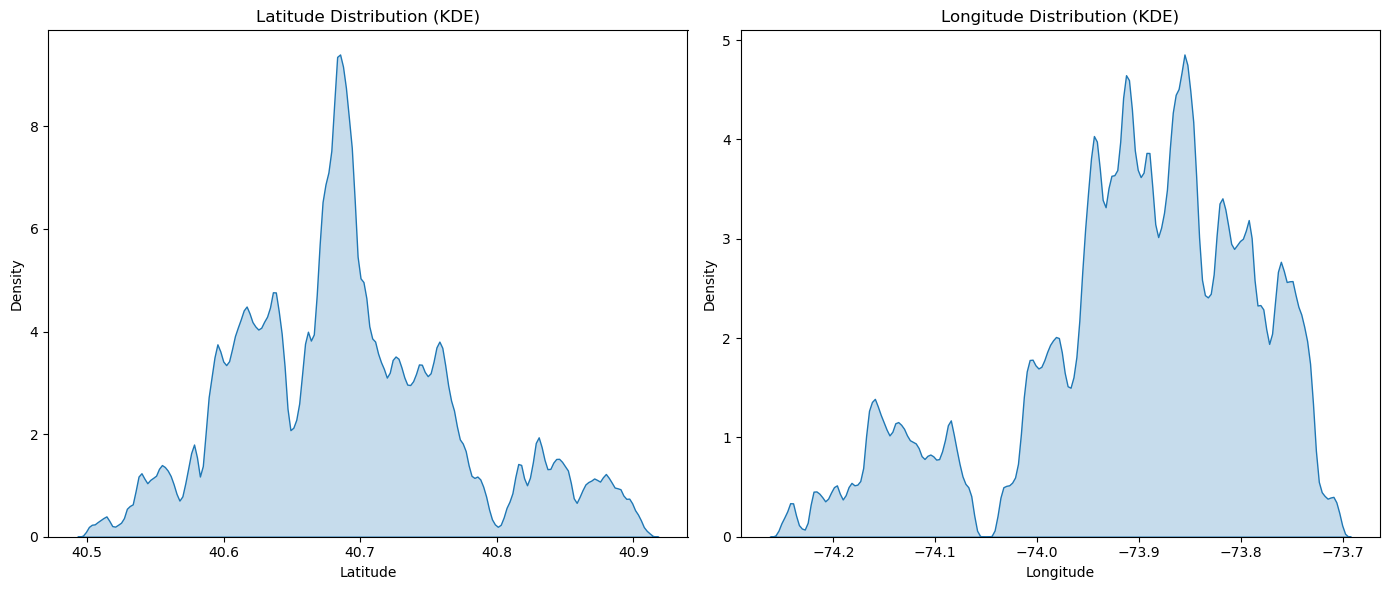

In [25]:
plt.figure(figsize=(14, 6))

# Latitude distribution
plt.subplot(1, 2, 1)
sns.kdeplot(data=nyc_df, x='LAT', bw_adjust=0.3, fill=True)
plt.title('Latitude Distribution (KDE)')
plt.xlabel('Latitude')

# Longitude distribution
plt.subplot(1, 2, 2)
sns.kdeplot(data=nyc_df, x='LNG', bw_adjust=0.3, fill=True)
plt.title('Longitude Distribution (KDE)')
plt.xlabel('Longitude')

plt.tight_layout()
plt.show()

In [26]:
from math import radians, cos, sin, asin, sqrt

def distance(lat2, long2, lat1, long1): 
    long1 = radians(long1) 
    long2 = radians(long2) 
    lat1 = radians(lat1) 
    lat2 = radians(lat2) 
       
    # Haversine formula  
    dlong = long2 - long1  
    dlat = lat2 - lat1 
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlong / 2)**2
  
    c = 2 * asin(sqrt(a))  
    r = 6371 # Radius of earth in kilometers
    return(c * r) 


nyc_df['DISTANCE'] = nyc_df.apply(lambda x: distance (x['LAT'],x['LNG'], 40.7128, -74.0060),axis=1)

convert data types

In [27]:
nyc_df.dtypes

BOROUGH                                    int64
BUILDING CLASS CATEGORY                    int64
TAX CLASS AT PRESENT                       int64
BLOCK                                      int64
LOT                                        int64
BUILDING CLASS AT PRESENT                  int64
ZIP CODE                                   int64
RESIDENTIAL UNITS                          int64
COMMERCIAL UNITS                           int64
TOTAL UNITS                                int64
LAND SQUARE FEET                           int64
GROSS SQUARE FEET                          int64
YEAR BUILT                                 int64
TAX CLASS AT TIME OF SALE                  int64
BUILDING CLASS AT TIME OF SALE             int64
SALE PRICE                                 int64
SALE DATE                         datetime64[ns]
LAT                                      float64
LNG                                      float64
MONTH                                      int32
DAYS                

In [28]:
# Get columns with int64 dtype
int_columns = nyc_df.select_dtypes(include=['int64', 'int32']).columns

# Convert int64 to float64
nyc_df[int_columns] = nyc_df[int_columns].astype('float64')

# Verify conversion
print("Column dtypes after conversion:")
print(nyc_df.dtypes)

Column dtypes after conversion:
BOROUGH                                  float64
BUILDING CLASS CATEGORY                  float64
TAX CLASS AT PRESENT                     float64
BLOCK                                    float64
LOT                                      float64
BUILDING CLASS AT PRESENT                float64
ZIP CODE                                 float64
RESIDENTIAL UNITS                        float64
COMMERCIAL UNITS                         float64
TOTAL UNITS                              float64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                               float64
TAX CLASS AT TIME OF SALE                float64
BUILDING CLASS AT TIME OF SALE           float64
SALE PRICE                               float64
SALE DATE                         datetime64[ns]
LAT                                      float64
LNG                                      float64
MONTH                                

In [29]:
nyc_df.reset_index(inplace=True)
nyc_df.drop(['index'],axis=1,inplace=True)

In [30]:
saved_path = os.path.join(folder_path, "nyc_sales_03_15_cleaned.csv")
nyc_df.to_csv(saved_path, index=False)

# 4. Preprocess for ingredients file

In [ ]:
mortgage_path = "../../Datasets/NYC_House_Price_Dataset/ingred/MORTGAGE.csv"
mortgage_df = pd.read_csv(mortgage_path)

In [ ]:
mortgage_df["observation_date"] = pd.to_datetime(mortgage_df["observation_date"])
mortgage_df["month"] = mortgage_df["observation_date"].dt.year * 12 + mortgage_df["observation_date"].dt.month
mortgage_df.drop(columns=["observation_date"], inplace=True)

start = 2003 * 12 + 1
end = 2015 * 12 + 12
mortgage_df = mortgage_df[(mortgage_df["month"] >= start) & (mortgage_df["month"] <= end)]
mortgage_df = mortgage_df.reset_index(drop=True)

In [ ]:
mortgage_df.to_csv("../../Datasets/NYC_House_Price_Dataset/ingred/MORTGAGE.csv", index=False)

In [ ]:
ur_path = "../../Datasets/NYC_House_Price_Dataset/ingred/NYUR.csv"
ur_df = pd.read_csv(ur_path)
ur_df["observation_date"] = pd.to_datetime(ur_df["observation_date"])
ur_df["month"] = ur_df["observation_date"].dt.year * 12 + ur_df["observation_date"].dt.month
ur_df.to_csv("../../Datasets/NYC_House_Price_Dataset/ingred/NYUR.csv", index=False)

In [ ]:
gdp_path = "../../Datasets/NYC_House_Price_Dataset/ingred/NYNQGSP.csv"
gdp_df = pd.read_csv(gdp_path)
gdp_df["observation_date"] = pd.to_datetime(gdp_df["observation_date"])
gdp_df["quarter"] = gdp_df["observation_date"].dt.year * 4 + gdp_df["observation_date"].dt.month // 3 + 1
gdp_df.to_csv("../../Datasets/NYC_House_Price_Dataset/ingred/NYNQGSP.csv", index=False)